In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

import re
import string
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

2023-08-28 19:05:25.368488: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# tf.config.experimental.enable_op_determinism()
tf.keras.utils.set_random_seed(42)

In [3]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
"Running in colab" if IN_COLAB else "Running locally"

'Running locally'

### Init wandb

In [4]:
if IN_COLAB:
  !pip install wandb -q
  !pip install python-dotenv -q
  !pip install ruamel.yaml -q

import wandb

from wandb.keras import (
   WandbMetricsLogger,
   WandbModelCheckpoint,
)
from ruamel.yaml import YAML

In [5]:
yaml = YAML(typ="safe")
with open("trans_params.yaml", "r") as file:
    config_file = yaml.load(file)

wandb.init(
    mode="disabled", # switch off logging for demonstration code
    project="CRNN_translate",
    config=config_file,
    save_code=True,
)
wandb.run.log_code(
    include_fn=lambda path: path.endswith(".ipynb") or path.endswith(".py")
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [6]:
UNITS = config["hidden_dims"]
input_dim = config["input_size"]

### Dataset loading

In [7]:
if IN_COLAB:
    # download dataset

    import pathlib

    path_to_zip = tf.keras.utils.get_file(
        "spa-eng.zip",
        origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
        extract=True,
    )

    path_to_file = pathlib.Path(path_to_zip).parent / "spa-eng/spa.txt"

    def load_data(path):
        text = path.read_text(encoding="utf-8")

        lines = text.splitlines()
        pairs = [line.split("\t") for line in lines]

        context = np.array([context for target, context in pairs])
        target = np.array([target for target, context in pairs])

        return target, context

    target_raw, context_raw = load_data(path_to_file)

    print(context_raw[-1])
    print(target_raw[-1])

else:
    df = pd.read_csv(
        "data/spa-eng.zip", delimiter="\t", names=["translate", "source", "attr"]
    )
    context_raw = np.array(df["source"])
    target_raw = np.array(df["translate"])
    print(context_raw[-1])
    print(target_raw[-1])

BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8


train_raw = (
    tf.data.Dataset.from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)
val_raw = (
    tf.data.Dataset.from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

Un día, me desperté y vi que Dios me había puesto pelo en la cara. Me lo afeité. Al día siguiente, vi que Dios me lo había vuelto a poner en la cara, así que me lo afeité otra vez. Al tercer día, cuando vi que Dios me había puesto pelo en la cara de nuevo, decidí que Dios se saliera con la suya. Por eso tengo barba.
One day, I woke up to find that God had put hair on my face. I shaved it off. The next day, I found that God had put it back on my face, so I shaved it off again. On the third day, when I found that God had put hair back on my face again, I decided to let God have his way. That's why I have a beard.


#### Dataset processing

In [8]:
def custom_standardization(text):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(
        text, "[%s]" % re.escape(string.punctuation + "¿¡"), ""
    )
    text = tf.strings.join(["[START]", text, "[END]"], separator=" ")
    return text


vocab_size = 5000
# sequence_length = 250


context_text_processor = tf.keras.layers.TextVectorization(
    standardize=custom_standardization, max_tokens=vocab_size, ragged=True
)

context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


['', '[UNK]', '[START]', '[END]', 'de', 'que', 'no', 'tom', 'a', 'la']

In [9]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=custom_standardization, max_tokens=vocab_size, ragged=True
)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'i', 'the', 'to', 'you', 'tom', 'a']

#### End of text processings

In [10]:
def process_text(context, target):
    context = context_text_processor(context).to_tensor()
    target = target_text_processor(target)
    targ_in = target[:, :-1].to_tensor()
    targ_out = target[:, 1:].to_tensor()
    return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [11]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [12]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match) / tf.reduce_sum(mask)

### define model

In [13]:
model_kwargs = {}
import os
os.environ["model"] = config["model"]
if config["model"] == "attention_gru":
    from attention_gru_translate_model import Translator

    model_kwargs = {"attention": True}
elif config["model"] == "gru":
    from context_rnn_translate_model import Translator
elif config["model"] == "crnn":
    from context_rnn_translate_model import Translator
elif config["model"] == "lstm":
    from context_rnn_translate_model import Translator
else:
    raise NotImplementedError("Model " + config["model"] + " is not implemented")

In [14]:
model = Translator(
    UNITS, context_text_processor, target_text_processor, input_dim, **model_kwargs
)

In [15]:
model.compile(
    optimizer=Adam(learning_rate=config["lr"], clipvalue=config["grad_clipping"]),
    loss=masked_loss,
    metrics=[masked_acc],
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=config["epochs"],
    # steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps=40,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6),
        WandbMetricsLogger(),
    ],
)

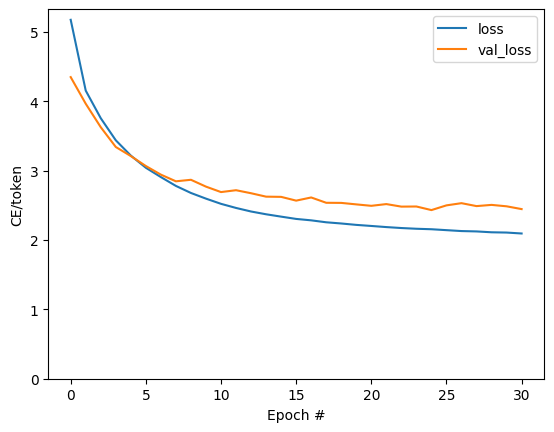

In [ ]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.ylim([0, max(plt.ylim())])
plt.xlabel("Epoch #")
plt.ylabel("CE/token")
plt.legend()

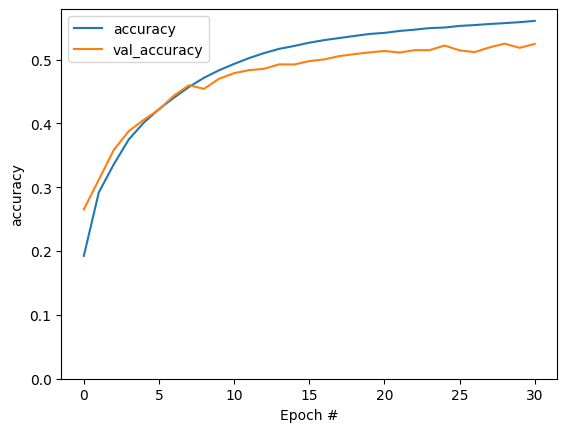

In [ ]:
plt.plot(history.history["masked_acc"], label="accuracy")
plt.plot(history.history["val_masked_acc"], label="val_accuracy")
plt.ylim([0, max(plt.ylim())])
plt.xlabel("Epoch #")
plt.ylabel("accuracy")
plt.legend()

In [ ]:
# result = model.translate(['¿Todavía está en casa?']) # Are you still home
# result[0].numpy().decode()

### Examples of translation

In [ ]:
text_table = wandb.Table(columns=["source", "translate", "target", "temperature"])
n_samples = 10

for context_strings, target_strings in train_raw.take(1):
    for temp in np.arange(0.1, 0.7, 0.1):
        translate_strings = model.translate(context_strings, temperature=temp)

        encoded_strings = [
            x.numpy() for x in [context_strings, translate_strings, target_strings]
        ]
        print("Temperature is", np.round(temp, 2))
        for i in range(min(len(context_strings), n_samples)):
            for t in encoded_strings:
                print(t[i].decode())
            print()
            text_table.add_data(*[t[i].decode() for t in encoded_strings], temp)

wandb.log({"training_samples": text_table})

Temperature is 0.1
Yo necesitaba ayuda.
i was a [UNK]                 
I needed help.

Estamos a tiempo.
they was a [UNK]                 
We're on time.

Tom no fue capaz de hacer lo que quería hacer.
tom doesnt want to be a [UNK]              
Tom wasn't able to do what he wanted to do.

Tom cantó suavemente.
tom is a [UNK]                 
Tom sang softly.

Tom ayudó a Mary ayer por la tarde.
tom was a [UNK] of the [UNK]              
Tom helped Mary yesterday afternoon.

Son mis hermanos.
it is a [UNK]                 
They are my brothers.

Prepárate.
are you                   
Stand by.

Aquí hay muchos mosquitos.
there is a [UNK]                 
There are a lot of mosquitoes here.

No es un sistema perfecto.
its not a [UNK]                 
It isn't a perfect system.

Para ese coche.
im a [UNK]                  
Stop that car.

Temperature is 0.2
Yo necesitaba ayuda.
i want to be                
I needed help.

Estamos a tiempo.
were you                  
We're on time.

Tom no

In [ ]:
# sentences from the paper

text_table = wandb.Table(columns=["source", "translate", "target", "temperature"])
n_samples = 10
context_strings = tf.constant(
    [
        "Debemos limpiar la cocina.",
        "Admit que estaba equivocada.",
        "Cual es el lugar mas bonito del mundo?",
        "La caja es pesada.",
    ]
)
target_strings = tf.constant(
    [
        "We must clean up the kitchen.",
        "I admitted that I was wrong.",
        "What's the most beautiful place in the world?",
        "The box is heavy.",
    ]
)
for temp in np.arange(0.1, 0.7, 0.1):
    translate_strings = model.translate(context_strings, temperature=temp)

    encoded_strings = [
        x.numpy() for x in [context_strings, translate_strings, target_strings]
    ]
    print("Temperature is", np.round(temp, 2))
    for i in range(min(len(context_strings), n_samples)):
        for t in encoded_strings:
            print(t[i].decode())
        print()
        text_table.add_data(*[t[i].decode() for t in encoded_strings], temp)

wandb.log({"paper_samples": text_table})

Temperature is 0.1
Debemos limpiar la cocina.
we must eat the kitchen  
We must clean up the kitchen.

Admit que estaba equivocada.
i was wrong to the [UNK] 
I admitted that I was wrong.

Cual es el lugar mas bonito del mundo?
its beautiful people to be [UNK] 
What's the most beautiful place in the world?

La caja es pesada.
the box is heavy   
The box is heavy.

Temperature is 0.2
Debemos limpiar la cocina.
we have to eat the table 
We must clean up the kitchen.

Admit que estaba equivocada.
i was wrong to the [UNK] 
I admitted that I was wrong.

Cual es el lugar mas bonito del mundo?
it is beautiful for the [UNK] 
What's the most beautiful place in the world?

La caja es pesada.
the box is heavy   
The box is heavy.

Temperature is 0.3
Debemos limpiar la cocina.
we must eat the table   
We must clean up the kitchen.

Admit que estaba equivocada.
i was [UNK]     
I admitted that I was wrong.

Cual es el lugar mas bonito del mundo?
what is beautiful people to be [UNK] 
What's 

In [ ]:
wandb.finish()

epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/masked_acc,▁▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇█████████████
epoch/val_loss,█▇▅▄▄▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_masked_acc,▁▂▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇█████████████
epoch/epoch,30
epoch/learning_rate,0.001
epoch/loss,2.0943
epoch/masked_acc,0.56062
epoch/val_loss,2.44614
